In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [4]:
T = 10
dt = 0.001

In [23]:
class ModifiedNobleModel:
    
    # Init
    def __init__(self):
        self.g_bk = 60 # +8.647058998212065
        self.e_bk = -91
        self.c_m = 0.001
        self.time = np.linspace(0, T, int(T/dt))
        self.c0 = 0.05
        self.tau_ex = 0.1
        self.v0 = -77.74845576817587 # -90
        self.m0 = 0.0536766093932326 # 0.027
        self.h0 = 0.7717018647717805 # 0.953
        self.n0 = 0.09710046626504293 # 0.036
        
        self.g_ca = 0.036
        self.v_ca1 = 100
        self.v_ca2 = -24
        self.r_ca = 8.5
        
    # Leaky term for [Ca2+]
    def r_ex(self, c):
        return (c-self.c0)/self.tau_ex
    
    # Na current
    def i_na(self, v, m, h):
        return (400*m**3*h + 0.14)*(v-40)
    
    # K current
    def i_k(self, v, n):
        g_k1 = 1.2 * np.exp((-v-90)/50) + 0.015*np.exp((v+90)/60)
        g_k2 = (1.2 + 1.0) * n**4
        return (g_k1 + g_k2) * (v+100)
    
    # Background current
    def i_bk(self, v):
        # return self.g_bk * (v - self.e_bk)
        g_bk = - (self.i_na(self.v0, self.m0, self.h0) \
        + self.i_k(self.v0, self.n0) \
        + 2*self.i_cal(self.v0))/(self.v0 - self.e_bk)
        return  g_bk * (v - self.e_bk)
    
    # Activate/Inactivate parameters
    def alpha_m(self, v):
        return 100 * (-v-48) / (np.exp((-v-48)/15) - 1)
    
    def beta_m(self, v):
        return 120 * (v+8) / (np.exp((v+8)/5) - 1)
    
    def alpha_h(self, v):
        return 170 * np.exp((-v-90)/20)
    
    def beta_h(self, v):
        return 1000 / (1 + np.exp((-v-42)/10))
    
    def alpha_n(self, v):
        return 0.1*(-v-50) / (np.exp((-v-50)/10) - 1)
    
    def beta_n(self, v):
        return 2*np.exp((-v-90)/80)
    
    def i_cal(self, v):
        return self.g_ca * \
    (v-self.v_ca1)/ (1 + np.exp(-(v-self.v_ca2)/ self.r_ca))
    
    # Stimulation
    def stim(self, t):
        if t >= 1 and t <= 1.1:
            return 0.5
        else:
            return 0
    
    # Right-hand side
    def rhs(self, y, t):
        c, v, m, h, n = y
        
        dcdt = -self.r_ex(c) + 0.05*self.stim(t)
        
        dvdt = - (self.i_na(v,m,h) + self.i_k(v,n) \
                  + self.i_bk(v) + 2*self.i_cal(v)\
                  - self.stim(t))/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        
        return [dcdt, dvdt, dmdt, dhdt, dndt]
    
    # Plot
    def plot(self, a, tmin=0, tmax=-1):
        
        plt.figure(figsize=(7,4))
        plt.plot(self.time[int(tmin/dt):int(tmax/dt)], a[int(tmin/dt):int(tmax/dt)])
        plt.show()
    
    # Time stepping
    def step(self):
        y0 = [self.c0, self.v0, self.m0, self.h0, self.n0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol

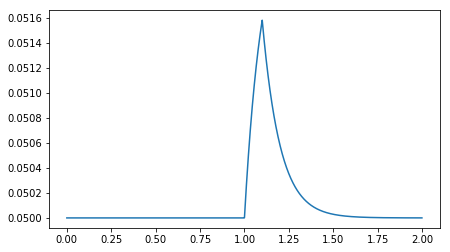

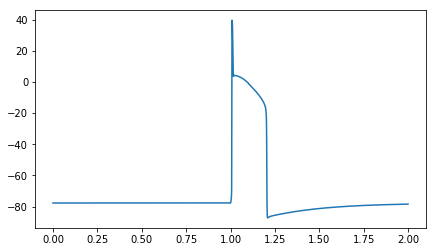

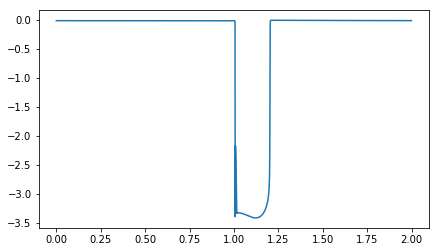

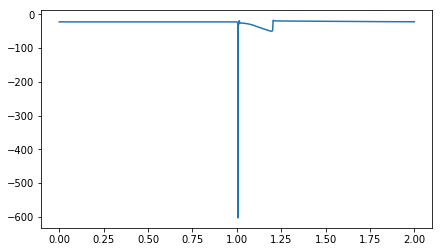

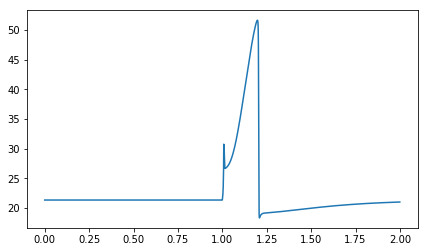

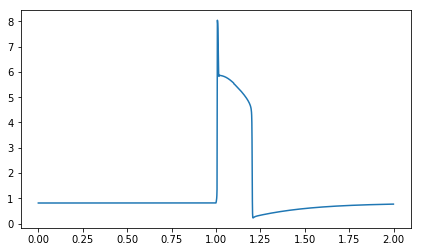

In [24]:
if __name__ == '__main__':
    model = ModifiedNobleModel()
    sol = model.step()
    model.plot(sol[:,0],0,2)
    model.plot(sol[:,1], 0, 2)
    model.plot(model.i_cal(sol[:,1]), 0, 2)
    model.plot(model.i_na(sol[:,1], sol[:,2], sol[:,3]), 0, 2)
    model.plot(model.i_k(sol[:,1], sol[:,4]), 0, 2)
    model.plot(model.i_bk(sol[:,1]), 0, 2)

## Find stable values

In [53]:
# aa = np.linspace(0,1,1000)

# dd = np.linspace(-150, 150, 1000)

# bb = model.alpha_n(-90) * (1-aa) - model.beta_n(-90) * aa

# np.where(bb == -min(np.abs(bb)))